### Background info

Followed the 3-year reliability paper: https://doi.org/10.1016/j.neuroimage.2021.118516
1. "Using these source estimates, we then estimated the power of cortical activity in the canonical frequency bands: delta (2–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (15–30 Hz), low gamma (30–80 Hz), and high gamma (80–150 Hz). We used Welch's method for estimating power spectrum densities (PSD) per four-second epoch across each MEG recording, with 1-second sliding Hamming windows overlapping at 50%. We then standardized the PSD values at each frequency bin to the total power across the frequency spectrum. We then averaged PSD maps (ie. source estimates) across epochs for each participant to obtain one set of six PSD maps (one per frequency band) per participant per visit."
2. "We projected these maps onto the MNI ICBM152 brain template (Fonov et al., 2009) and applied a 3 mm FWHM smoothing kernel."
3. "Used single rater two-way mixed-effects model and absolute agreement definition, or ICC(A,1)... ICC estimates and their 95% confidence intervals were calculated using the Matlab Central file-exchange ICC.m function. This ICC calculation was applied at every vertex in the PSD maps to obtain spatially specific reliability estimates at each of the frequency bands. This resulted in an ICC map per frequency band."
4. "To further visualize the reliability of source power in each frequency band, regions of interest (Brainstorm “scouts”) in the frontal, parietal, temporal, and occipital lobes were applied to each participant's PSD map. The average power (relative to total spectral power) across each lobe was extracted for each participant and each visit. ICCs of these values were then calculated using the same ICC(A,1) model."
- "ICC .5 indicates poor reliability, values between .5 to .75 indicates moderate reliability, values between .75 and .9 indicates good reliability, and values greater than .9 indicate excellent reliability. Importantly, we evaluated the level of reliability based on the 95% confidence interval of the ICC estimate, not the estimate itself, since the interval reveals the chance that the true ICC value lands on any point between the bounds."


### Set up

In [3]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import pickle as pkl
import mne
import copy as copy
from pathlib import Path
import csv
import pingouin as pg

base_dir = "C:/meg/NVAR_ICC/derivatives"

# Things to loop through
# dictionary = { # OLD VERSION
#     "NVAR008": ["251016", "251017", "251023", "251113"], 
#     "NVAR010": ["251027", "251028", "251103", "251124"], 
#     "NVAR011": ["251030", "251031", "251106", "251127"]
# }
dictionary = { # NEW VERSION
    "NVAR008": ["Day1", "Day2", "Day3", "Day4"], 
    "NVAR010": ["Day1", "Day2", "Day3", "Day4"], 
    "NVAR011": ["Day1", "Day2", "Day3", "Day4"]
}
runs = ["rest1", "rest2"]
bands = ["alpha", "beta", "delta", "g_high", "g_low", "theta"]


### Morph and average

generic_taskfree_MEGIN.py Add this change: 
- stc_band_base = Path(os.path.basename(path2raw)).stem + f"_{inv_method}_{band}_stc"
- stc_band_path = os.path.join(stc_dir, stc_band_base)
- stc_band.save(stc_band_path, overwrite=True)


Here, create morph and apply
- The 3yr reliability paper applied a 3mm smoothing kernel, but can't do this in mne python! Caution that the smoothing param that is part of the morph function does not do what you think it does
- Save morphed_stc_per_band -> end up with 5 stcs per run per participant

Sources: 
- https://mne.tools/stable/auto_examples/inverse/morph_surface_stc.html

Then, compute average over rest1 and rest2!

In [ ]:
for subject in dictionary: 
    for session in dictionary[subject]:
        for band in bands: 
            for run in runs: 

                # Make file name
                stc_dir = os.path.join(base_dir, "sub_" + subject, session, "beamformer", "stc")
                stc_basename = os.path.join(stc_dir, "sub_" + subject + "_" + run + "_raw_tsss_beamformer_" + band + "_stc")
                print("Input: " + stc_basename)
                print("Output: " + stc_basename + "_morphed")

                # Read in file
                stc = mne.read_source_estimate(stc_basename)

                # Create morph
                morph = mne.compute_source_morph(
                    stc,
                    subject_from = 'sub_' + subject, 
                    subject_to = "fsaverage", # to fsaverage
                    subjects_dir = "C:/meg/NVAR_ICC/MRI/freesurfer/"
                    )
                # Apply morph
                stc_morphed = morph.apply(stc)
                stc_morphed.save(stc_basename + "_morphed", overwrite = True)

            # Make file name
            stc_dir = os.path.join(base_dir, "sub_" + subject, session, "beamformer", "stc")
            stc_morphed_rest1_name = os.path.join(stc_dir, "sub_" + subject + "_rest1_raw_tsss_beamformer_" + band + "_stc_morphed")
            stc_morphed_rest2_name = os.path.join(stc_dir, "sub_" + subject + "_rest2_raw_tsss_beamformer_" + band + "_stc_morphed")
            stc_average_name = os.path.join(stc_dir, "sub_" + subject + "_average_raw_tsss_beamformer_" + band + "_stc_morphed")
            
            # Compute average
            stc_morphed_rest1 = mne.read_source_estimate(stc_morphed_rest1_name)
            stc_morphed_rest2 = mne.read_source_estimate(stc_morphed_rest2_name)
            stc_average = (stc_morphed_rest1 + stc_morphed_rest2)/2
            stc_average.save(stc_average_name, overwrite = True)

In [18]:
# CHECKING

rest1 = mne.read_source_estimate("C:/meg/NVAR_ICC/derivatives/sub_NVAR008/Day1/beamformer/stc/sub_NVAR008_rest1_raw_tsss_beamformer_beta_stc_morphed")
#rest2 = mne.read_source_estimate("C:/meg/NVAR_ICC/derivatives/sub_NVAR008/251113/beamformer/stc/sub_NVAR008_rest2_raw_tsss_beamformer_beta_stc_morphed")
#average = mne.read_source_estimate("C:/meg/NVAR_ICC/derivatives/sub_NVAR008/251113/beamformer/stc/sub_NVAR008_average_raw_tsss_beamformer_beta_stc_morphed")
#og = mne.read_source_estimate("C:/meg/NVAR_ICC/derivatives/sub_NVAR008/251113/beamformer/stc/sub_NVAR008_rest1_raw_tsss_beamformer_beta_stc_morphed")

brain = rest1.plot(
    subject = "fsaverage", 
    subjects_dir = "C:/meg/NVAR_ICC/MRI/freesurfer/", 
    initial_time = 0, 
    hemi = "both", 
    time_viewer = True
)

Using pyvistaqt 3d backend.
Using control points [0.00351941 0.00363977 0.00418828]
False


### ICC
What you have at this point is one morph-average stc plot per band per day (day 1, day 2, day 3, day 4)
Need to calculate ICC for each band

**Paper trail of decisions:**

What past people have used: 
- 3-year reliability paper: single rater, two-way mixed-effects, absolute agreement (or ICC(A,1)) using matlab ICC.m
- spectral stability paper: single-rater, two-way mixed-effects, absolute agreement, using matlab ICC.m

What I will use: single rater, two-way mixed-effects, absolute agreement (or ICC(A,1))
- Based on examples above, as well as other sources: https://rowannicholls.github.io/python/statistics/agreement/intraclass_correlation.html, https://pmc.ncbi.nlm.nih.gov/articles/PMC4913118/  
- Model: Two-way mixed effects. This means same set of raters for all subjects. Mixed  means that raters are the only raters of interest; cannot be generalized to population. Note that results from two-way random effects would be the same.
- Definition: absolute agreement (how much different raters' ratings agree) (rather than consistency, which is a measure of if raters scores for same subject are correlated)

Looking into matlab ICC.m: 
- https://www.mathworks.com/matlabcentral/fileexchange/22099-intraclass-correlation-coefficient-icc 
- Based on this paper: McGraw, K. O., Wong, S. P., "Forming Inferences About Some Intraclass Correlation Coefficients", Psychological Methods, Vol. 1, No. 1, pp. 30-46, 1996  
- Looked at formula for ICC(A, 1)
- I want to use python. Which code in the python Pingouin ICC (https://github.com/raphaelvallat/pingouin/blob/dcfdc82bbc7f1ba5991b80717a5ca156617443e8/pingouin/reliability.py#L158) corresponds to this formula? Answer: ICC2 "Single random raters"




In [ ]:
# DAYS AS RATERS
"""
Shape of stc_average: 
array([[0.0053271 ],
       [0.00452035],
       [0.005533  ],
       ...,
       [0.00313858],
       [0.003465  ],
       [0.00346861]], shape=(20484, 1), dtype=float32)
"""

# Loop through bands
# for band in bands: 
band = "alpha" # test

# Vertex-wise ICC
df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

# Loop through vertices
# There are 20484 vertices
for vertex in range(20484): 

    df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject, session, power

    # Add the value for this vertex for average-morph for each subject/session 
    for subject in dictionary: 
        for session in dictionary[subject]: 
            
            stc_dir = os.path.join(base_dir, "sub_" + subject, session, "beamformer", "stc")
            stc_average_name = os.path.join(stc_dir, "sub_" + subject + "_average_raw_tsss_beamformer_" + band + "_stc_morphed")
            stc = mne.read_source_estimate(stc_average_name)
            power = stc.data[vertex]

            df_vertex.loc[len(df_vertex)] = [subject, session, power[0]]

    # Compute ICC on this
    results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
    icc2 = results.loc[1, 'ICC']
    ci = results.loc[1, "CI95%"]

    # Add to big df
    df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/vertexwise_ICC_" + band + ".pkl", "wb") as f: 
        pkl.dump(df, f)

C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)


Results of ICC on alpha, with days as raters, for day average, on 3 subjects: 

Lower bound of CI is average 0.54 and upper bound is average ~1 - clearly this is not working
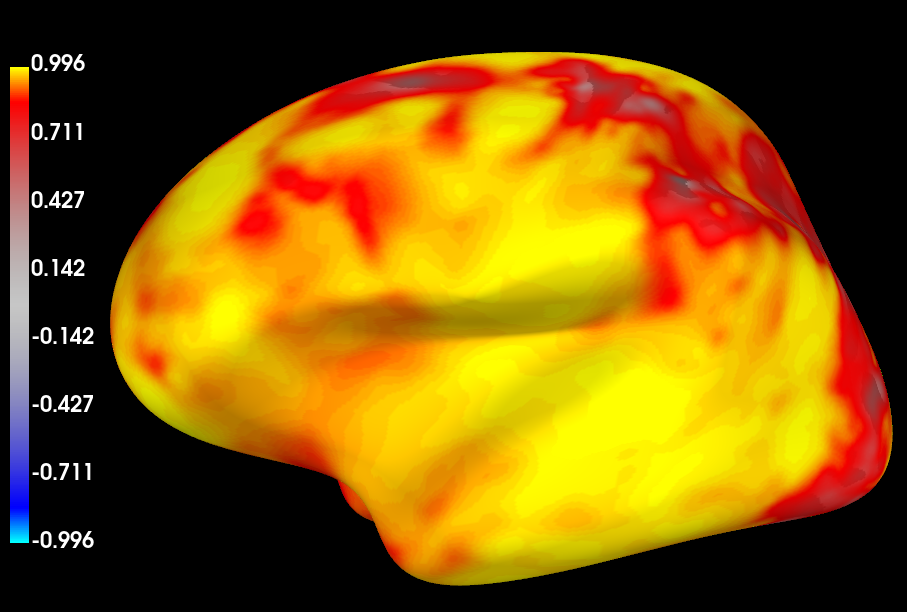

In [82]:
# RATERS: SESSION+RUN

# Loop through bands 
for band in bands: 

    # Vertex-wise ICC
    df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

    # Loop through vertices
    # There are 20484 vertices
    for vertex in range(20484): 

        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject, run/session, power

        # Add the value for this vertex for average-morph for each subject/session 
        for subject in dictionary: 
            for session in dictionary[subject]: 
                for run in ["rest1", "rest2"]: 

                    stc_dir = os.path.join(base_dir, "sub_" + subject, session, "beamformer", "stc")
                    stc_name = os.path.join(stc_dir, "sub_" + subject + "_" + run + "_raw_tsss_beamformer_" + band + "_stc_morphed")
                    stc = mne.read_source_estimate(stc_name)
                    power = stc.data[vertex]

                    df_vertex.loc[len(df_vertex)] = [subject, session + run, power[0]]

        # Compute ICC on this
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[1, 'ICC']
        ci = results.loc[1, "CI95%"]

        # Add to big df
        df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/ICC_" + band + ".pkl", "wb") as f: 
        pkl.dump(df, f)

C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

In [ ]:
for band in bands: 

    with open("C:/meg/NVAR_ICC/ICC_" + band + ".pkl", "rb") as f: 
        df = pkl.load(f)

    stc_icc2 = mne.SourceEstimate(
        data = df["ICC2"].to_numpy(),
        vertices = [np.arange(0, 10242), np.arange(0, 10242)], 
        tmin=0,
        tstep=1,
        subject="fsaverage"
    )

    brain = stc_icc2.plot(
        subject = "fsaverage", 
        subjects_dir = "C:/meg/NVAR_ICC/MRI/freesurfer/", 
        initial_time = 0, 
        hemi = "both", 
        time_viewer = False, 
        clim = dict(kind='value', lims=(0, 0.75, 1))
    )
    brain.show_view("dorsal")
    brain.save_image("C:/meg/NVAR_ICC/" + band + "_dorsal.png")

NameError: name 'bands' is not defined

Alpha: 
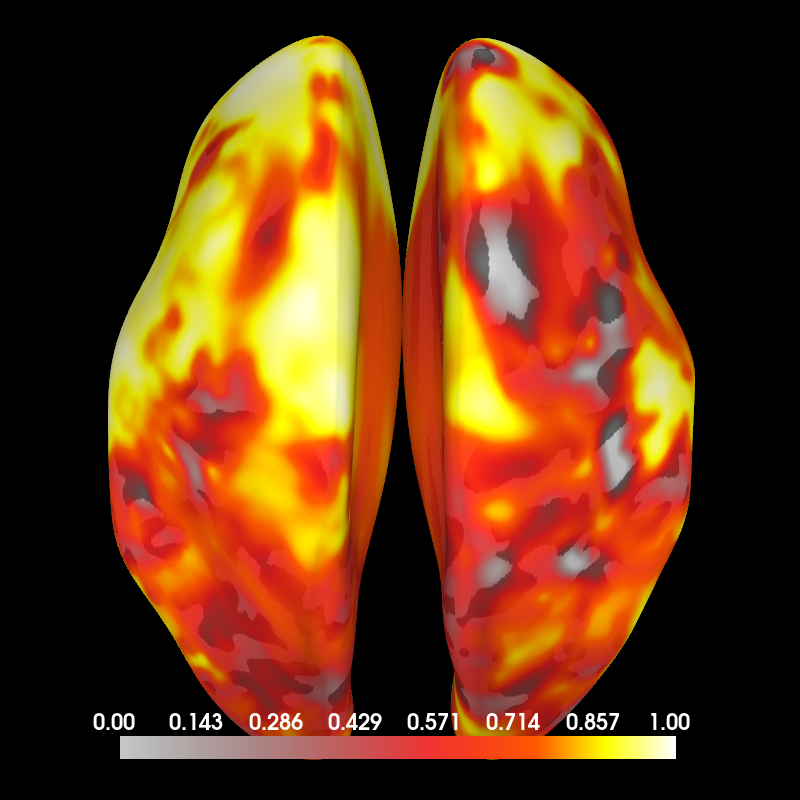
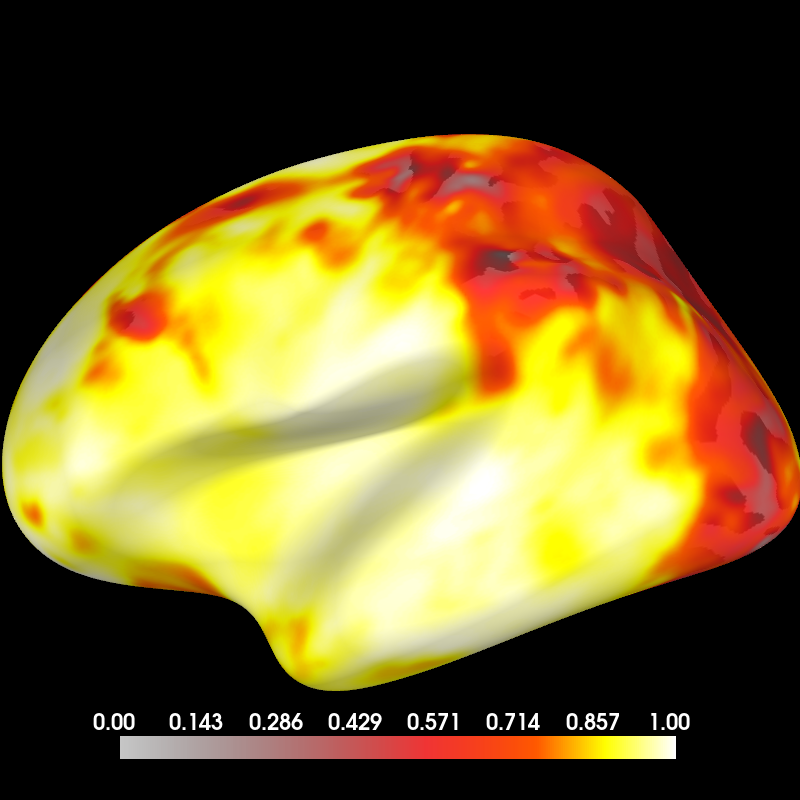

Beta: 
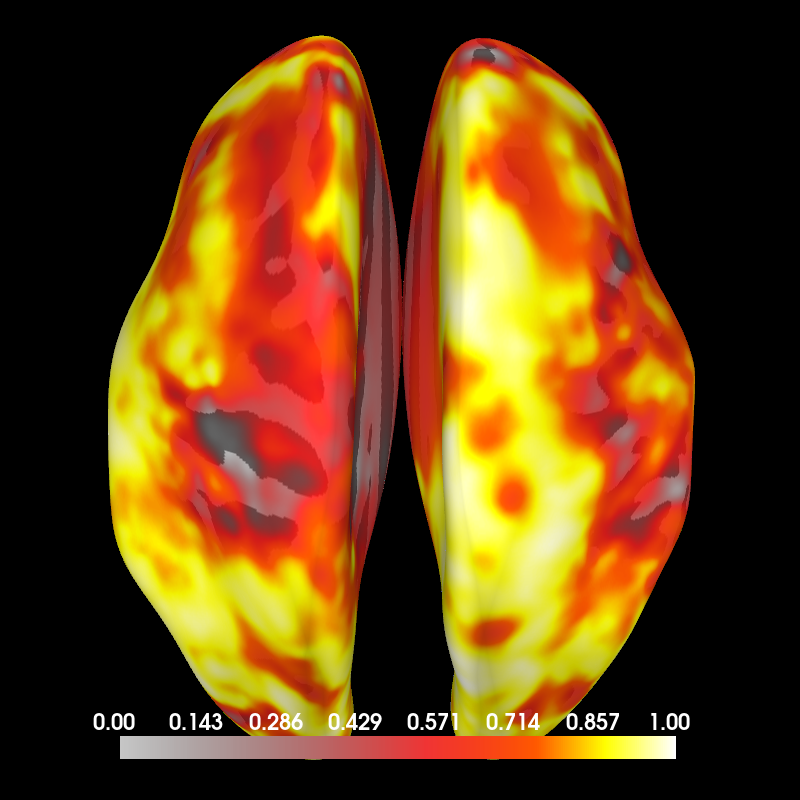
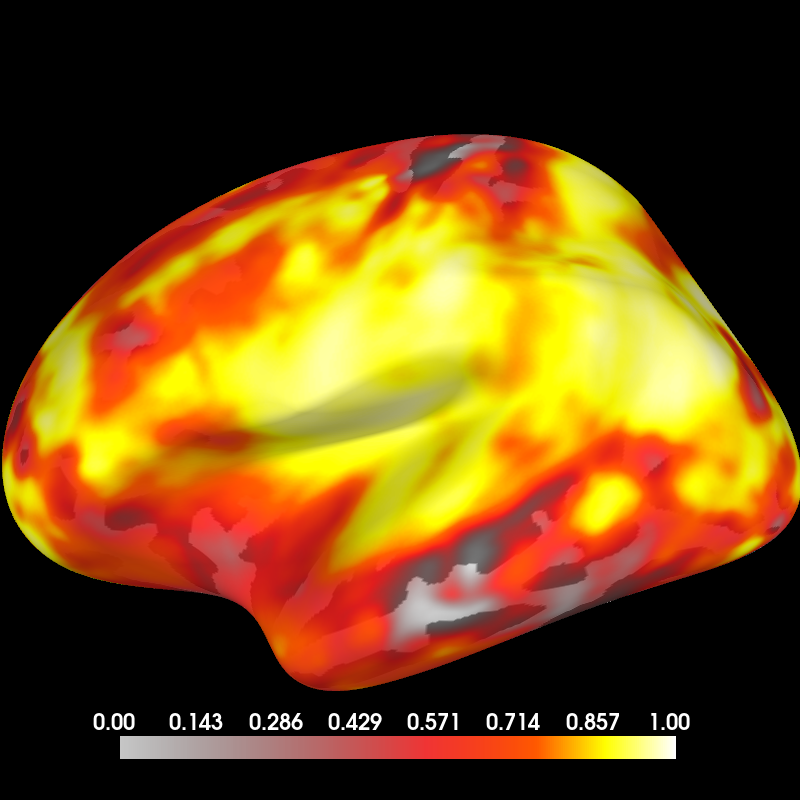

Delta: 
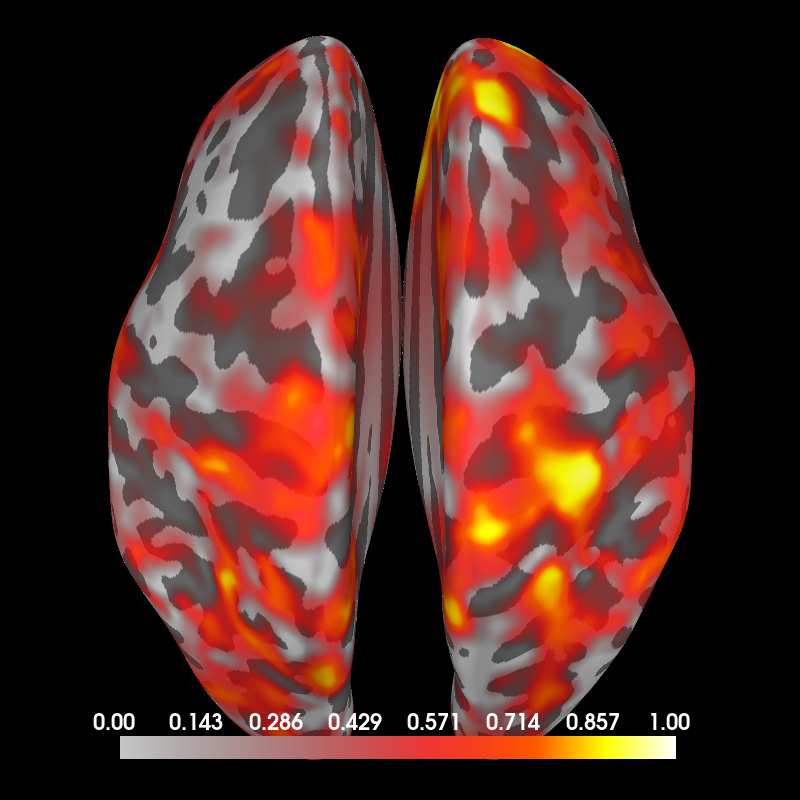
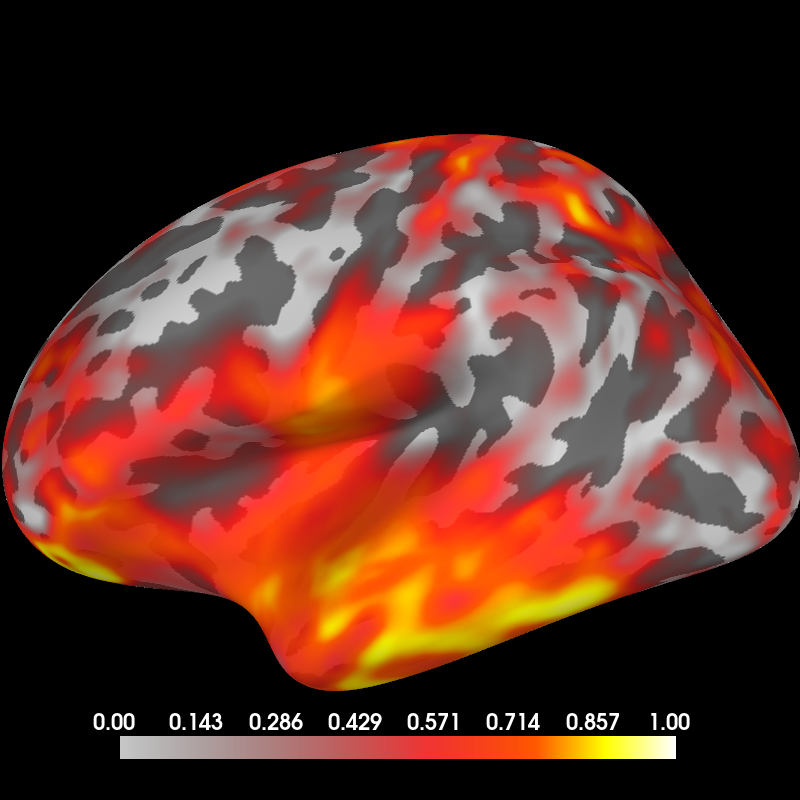

Low gamma: 
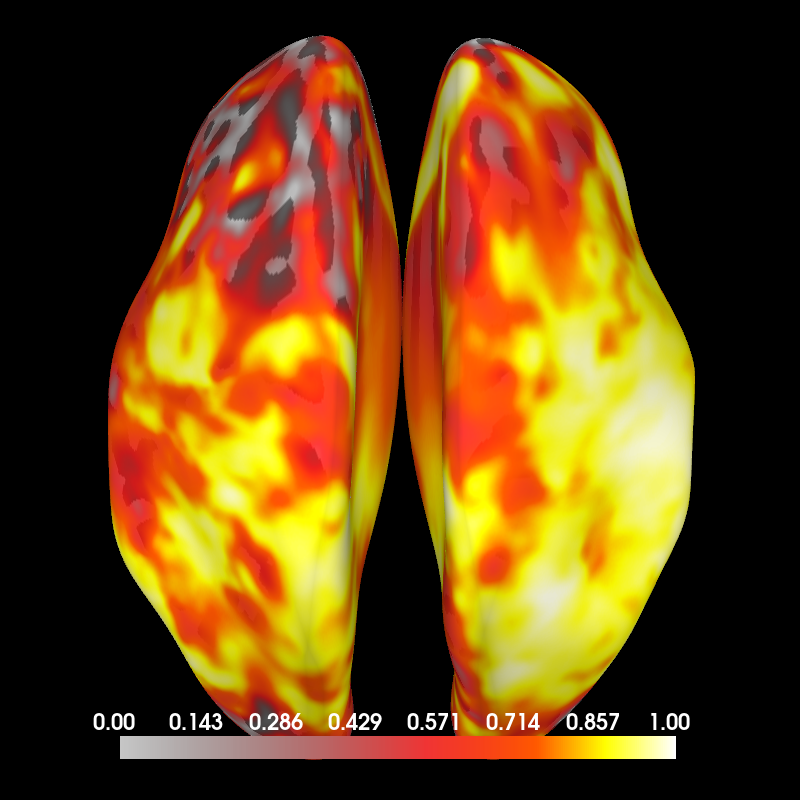
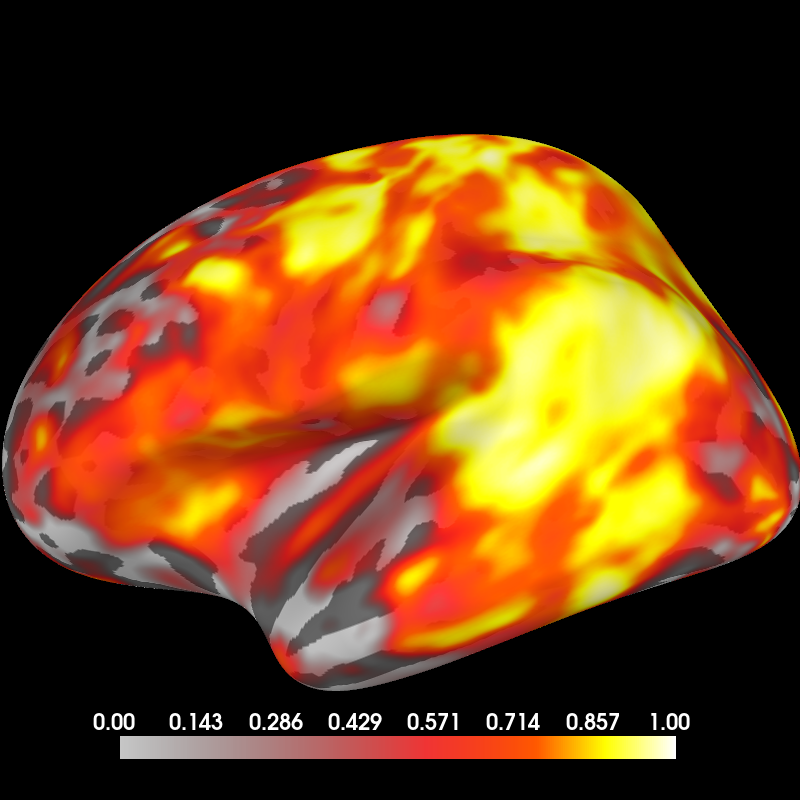

Theta: 
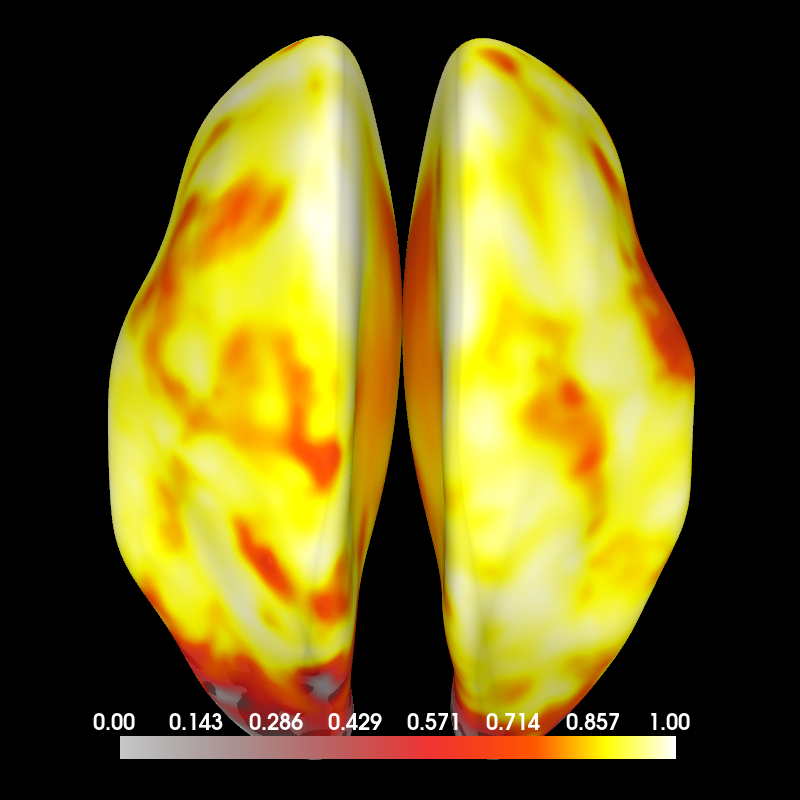
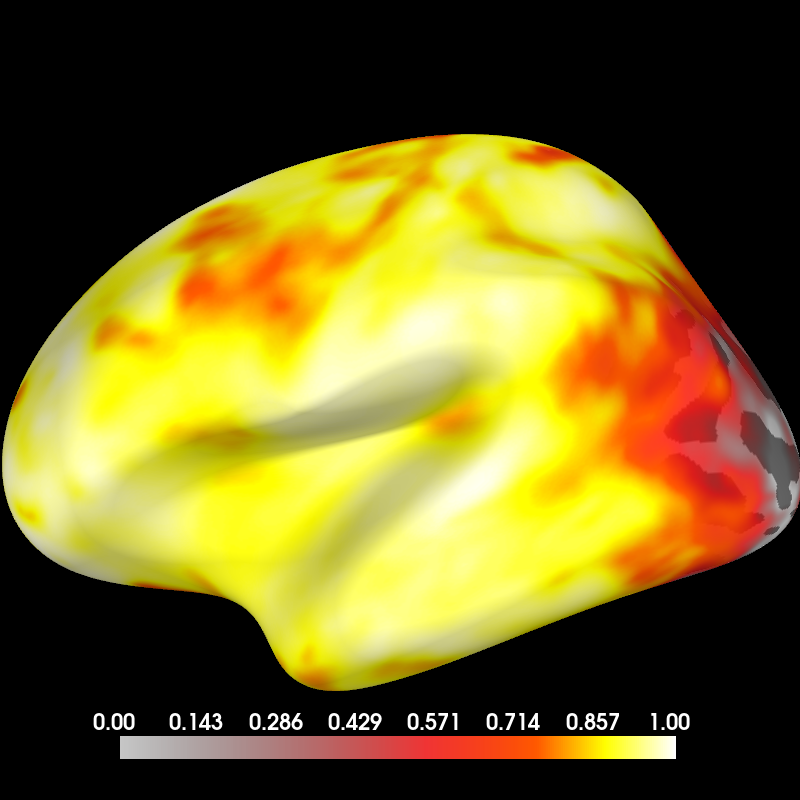

**min 95CI average**
alpha
- 0.44637846018649613
beta
- 0.3405941802558344
False
delta
- 0.08492597840426051
False
- g_high
0.19642508302402814
False
g_low
- 0.3290521072422718
False
theta
- 0.4954430935989454

np.float64(0.4954430935989454)